# Exercise 2.2 - Random Matrix theory

In [1]:
from pathlib import Path

import numpy as np
import networkx as nx
import scipy.sparse
import matplotlib.pyplot as plt
import tqdm.contrib.concurrent

import disordered_sys.generate
import disordered_sys.methods

In [2]:
epsilon = 1e-3
c = 3
n = 2**10
lam = 0
figure_dir = Path.cwd() / ".." / "report" / "figures"

m, g = disordered_sys.generate.generate_m(c, n, return_g=True)

### Implement cavity equation

In [3]:
def get_neighbors(g, k, j=-1):
    neighbors_set = set(g.neighbors(k)) - {j}
    return np.array(list(neighbors_set))

def cavity_equation(m, g, cav_precs, lam, k, j=-1):
    n_idxs = get_neighbors(g, k, j)
    n_weights = m[k, n_idxs]**2
    prec_weights = cav_precs[k, n_idxs].todense()

    return epsilon + 1j * lam + np.sum(n_weights / prec_weights)

### Initialize Marginal Cavity Precisions

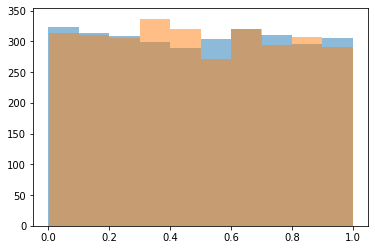

In [4]:
cavity_init = np.random.uniform(size=len(g.edges) * 2) + 1j * np.random.uniform(size=len(g.edges) * 2)
plt.hist(cavity_init.real, alpha=.5)
plt.hist(cavity_init.imag, alpha=.5)
plt.savefig(figure_dir / "ex2_cavity_init_hist.pdf")

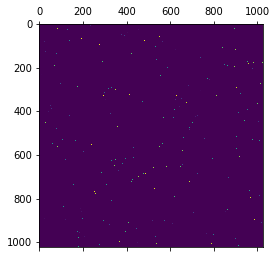

In [5]:
adj_mat = nx.to_scipy_sparse_array(g, nodelist=sorted(list(g.nodes())))
cavity_init = adj_mat[adj_mat.nonzero()] * cavity_init
cavity_precs = scipy.sparse.coo_matrix((cavity_init, adj_mat.nonzero()))
cavity_precs = cavity_precs.tocsr(copy=False)
plt.matshow(cavity_precs.todense().real)
plt.savefig(figure_dir / "ex2_cavity_init_mat.pdf")

In [6]:
def init_cavity_precs(g):
    cavity_init = np.random.uniform(size=len(g.edges) * 2) + 1j * np.random.uniform(size=len(g.edges) * 2)
    adj_mat = nx.to_scipy_sparse_array(g, nodelist=sorted(list(g.nodes())))
    cavity_init = adj_mat[adj_mat.nonzero()] * cavity_init
    cavity_precs = scipy.sparse.coo_matrix((cavity_init, adj_mat.nonzero()))
    cavity_precs = cavity_precs.tocsr(copy=False)
    return cavity_precs

### Run the Cavity method to obtain Marginal Cavity Precisions

In [7]:
tol = 1e-10
delta = np.inf

while delta > tol:
    reference = cavity_precs.copy()
    for k, j in g.to_directed().edges:
        cavity_precs[j, k] = cavity_equation(m, g, cavity_precs, lam, k, j)
    delta = np.max(np.abs(cavity_precs - reference))
    print(f"{delta=:.4e}", end="\r")

KeyboardInterrupt: 

### Show the distributions of Marginal Cavity Precisions

In [ ]:
plt.hist(np.array(cavity_precs[cavity_precs.nonzero()]).flatten().real, bins=n // 2)
plt.savefig(figure_dir / "ex2_cavity_precs_real.pdf")

In [ ]:
plt.hist(np.array(cavity_precs[cavity_precs.nonzero()]).flatten().imag, bins=n // 2)
plt.savefig(figure_dir / "ex2_cavity_precs_imag.pdf")

### Calculate the Marginal Precisions

In [ ]:
marginals = np.sum(cavity_precs, axis=1)  # type: ignore
print(marginals)

In [ ]:
plt.hist(marginals.real)
plt.savefig(figure_dir / "ex2_marginal_precs_real.pdf")

### Calculate the spectral density

In [ ]:
G_ii = 1j / marginals
rho_lambda = G_ii.imag.mean() / np.pi
print(rho_lambda)

### Sweep over different $\lambda$

In [ ]:
lambdas = np.linspace(-3, 3, num=25)

def spectral_density(lam):
    cavity_precs = init_cavity_precs(g)

    delta = np.inf
    while delta > tol:
        reference = cavity_precs.copy()
        for k, j in g.to_directed().edges:
            cavity_precs[j, k] = cavity_equation(m, g, cavity_precs, lam, k, j)
        delta = np.max(np.abs(cavity_precs - reference))

    marginals = np.sum(cavity_precs, axis=1)  # type: ignore
    G_ii = 1j / marginals
    rho_lambda = G_ii.imag.mean() / np.pi
    return rho_lambda

spectrum = tqdm.contrib.concurrent.process_map(spectral_density, lambdas)

In [ ]:
plt.plot(spectrum)